https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data

1. Explore dataset – correlation between features, their impact on target, independence assumptions
2. Try multiple visualization strategies: correlation plots, dimensionality reduction approaches – PCA, UMAP, t-SNE. Explain gained insights
3. Explore data using unsupervised learning techniques
4. Identify appropriate cross-validation strategy
5. Train a simple model first. Use validation set for hyperparameter tuning and/or early stopping. Analyze its performance using cross-validation. Identify potential pitfalls.
6. Propose ways to improve performance – e.g., feature selection, regularization, increasing model complexity. Conduct at least 2 more experiments.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import umap
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, silhouette_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

data=data.drop(columns=['id'])
data.info()
data.shape
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
X = data.drop(columns=['stroke'])  # Features
y = data['stroke']                 # Target

all_numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features=X.select_dtypes(include=['object']).columns.tolist()
# Separate binary features (columns with exactly 2 unique values)
print(categorical_features)
print(all_numerical_features)
binary_features = [col for col in all_numerical_features if X[col].nunique() == 2]

print(binary_features)
# Update numerical_features to exclude binary features
numerical_features = [col for col in all_numerical_features if col not in binary_features]

print(numerical_features)
# Handle missing values in numerical features
imputer = SimpleImputer(strategy='mean')
X[numerical_features] = imputer.fit_transform(X[numerical_features])

# X[numerical_features] = X[numerical_features].round(2)
X.head()

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
['hypertension', 'heart_disease']
['age', 'avg_glucose_level', 'bmi']


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked


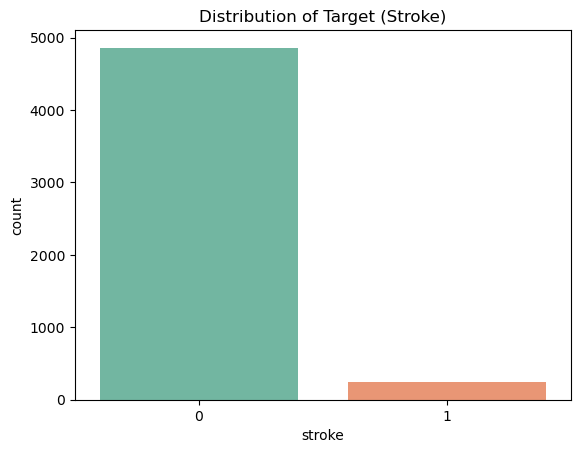

stroke
0    4861
1     249
Name: count, dtype: int64

In [4]:
sns.countplot(x='stroke', data=data,hue='stroke', palette="Set2",dodge=False, legend=False)
plt.title("Distribution of Target (Stroke)")
plt.show()

y.value_counts()

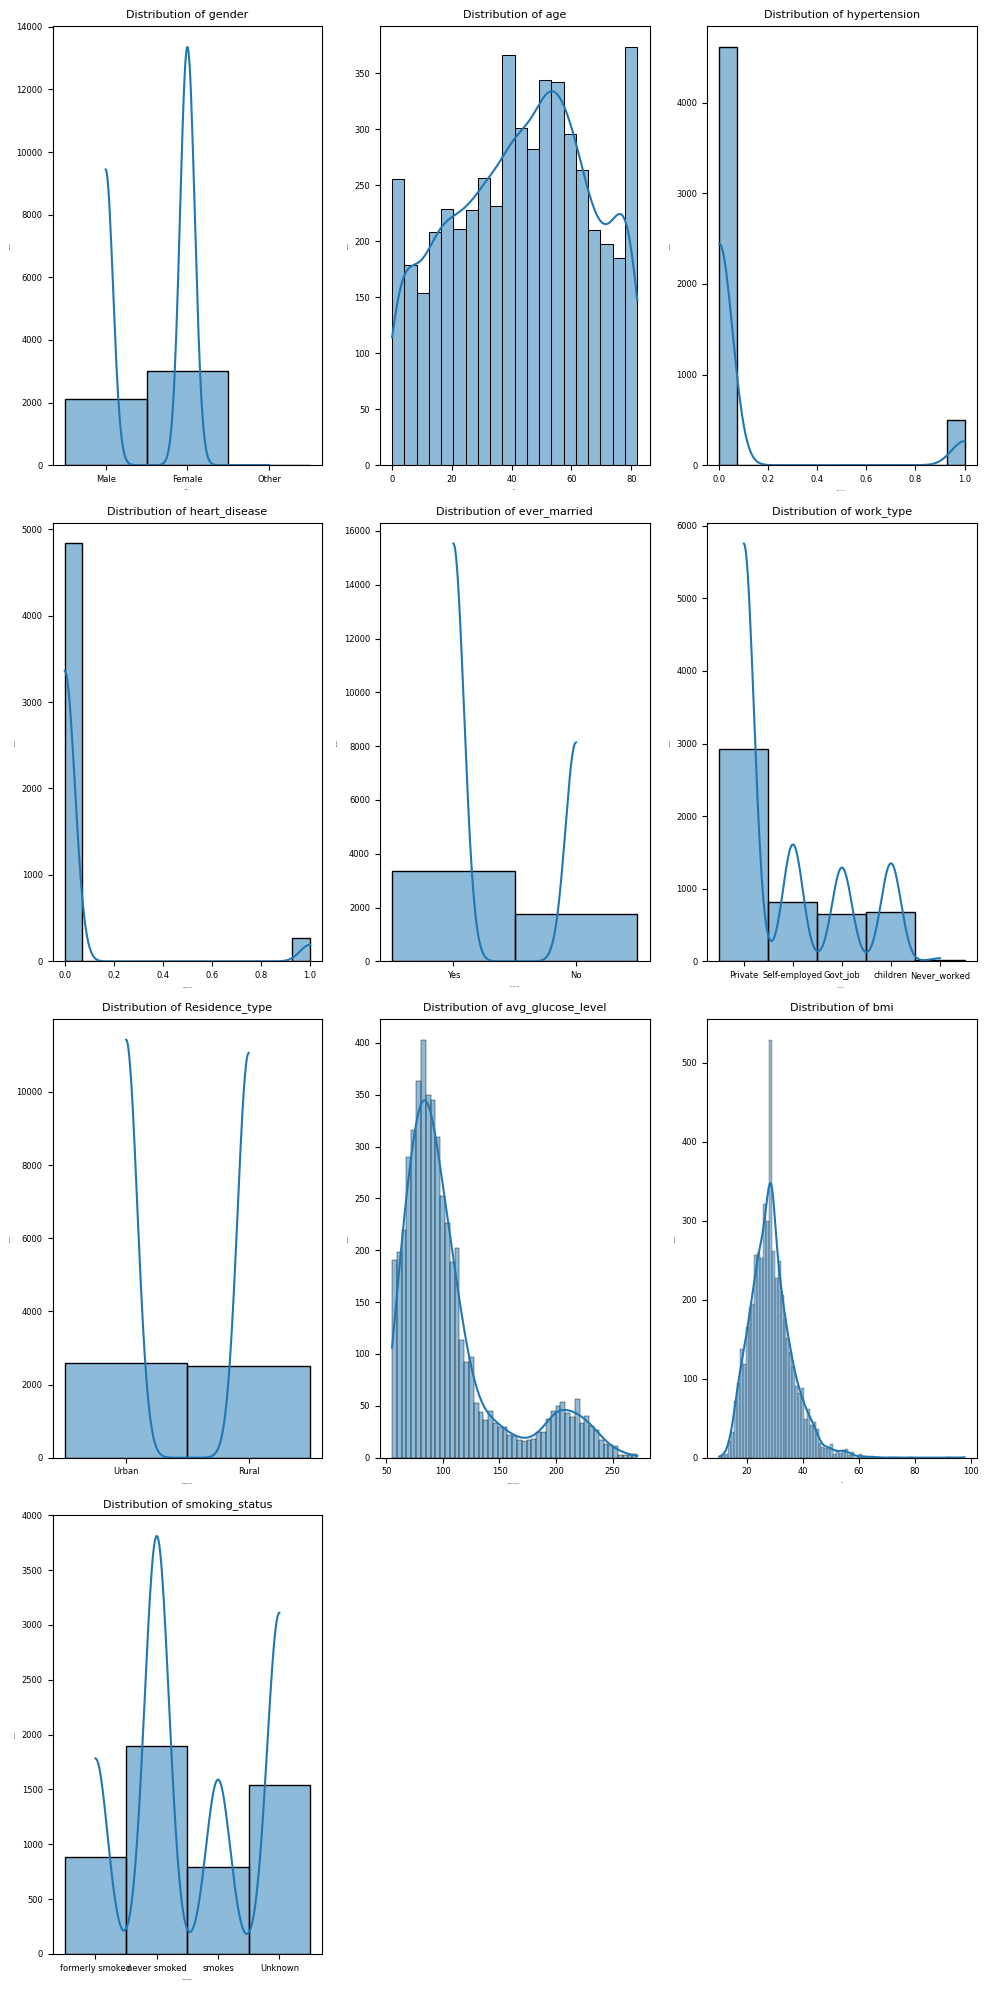

In [5]:
# Exploring distribution of the data
num_features = X.shape[1]
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols  # Calculates rows to fit all features

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 20))
axes = axes.flatten()

# Plot each feature
for i, column in enumerate(X.columns):
    sns.histplot(X[column], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {column}', fontsize=8)
    axes[i].set_xlabel(column, fontsize=0)
    axes[i].set_ylabel('Frequency', fontsize=0)
    axes[i].tick_params(axis='both', labelsize=6)

# Hide any extra subplots if there are fewer than rows * cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

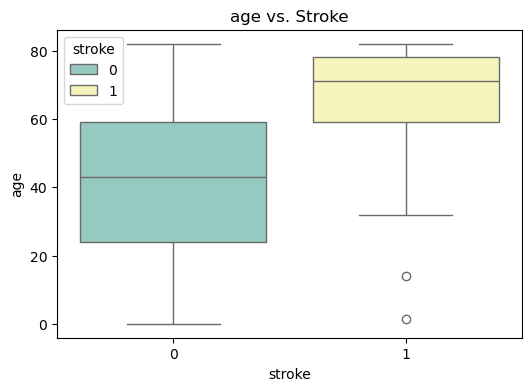

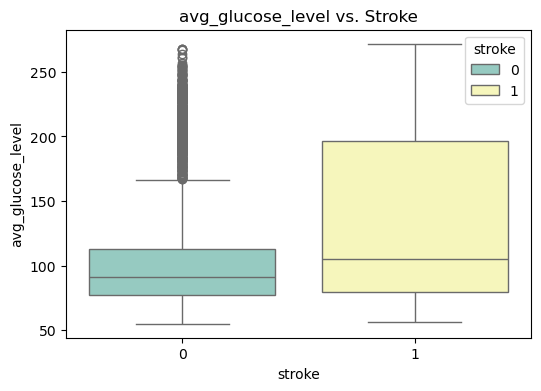

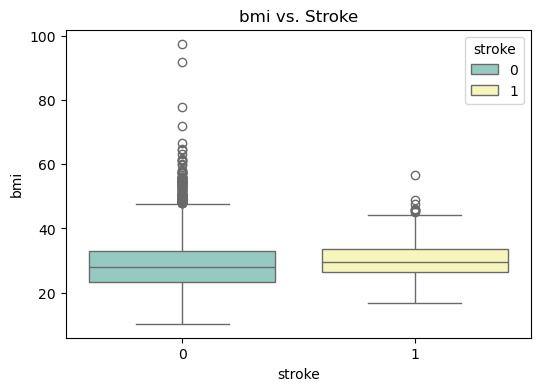

In [6]:
for column in data[numerical_features]:
    if column != 'stroke':
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='stroke', y=column, data=data,hue='stroke', palette="Set3")
        plt.title(f"{column} vs. Stroke")
        plt.show()

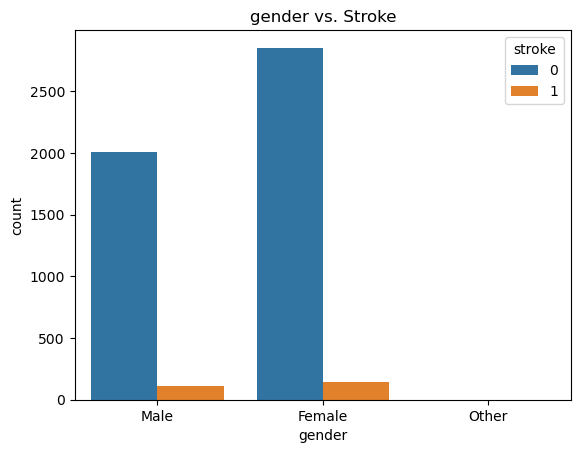

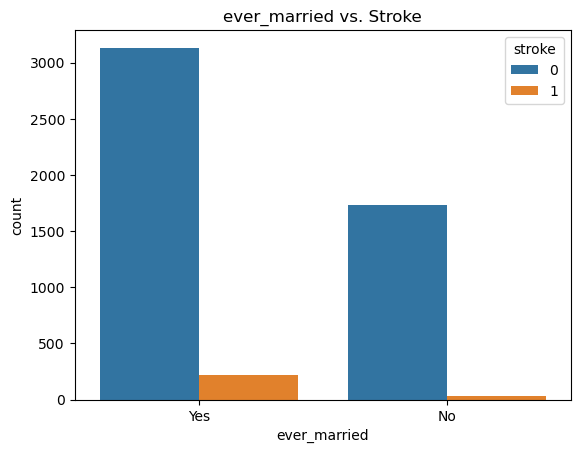

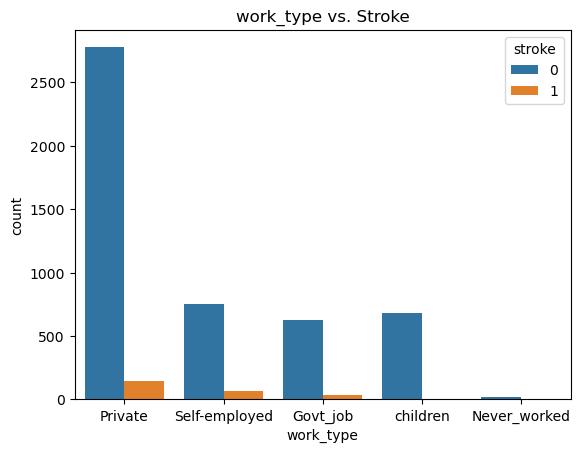

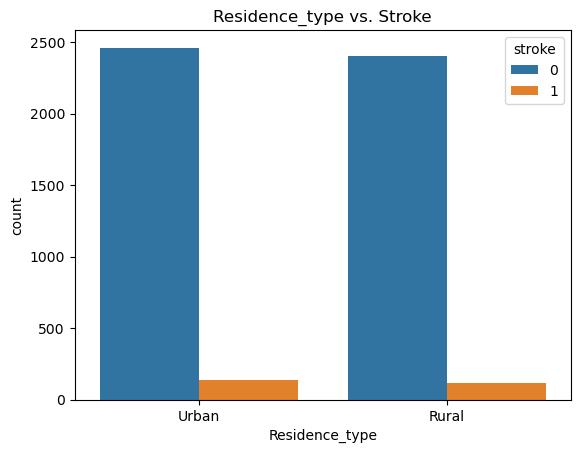

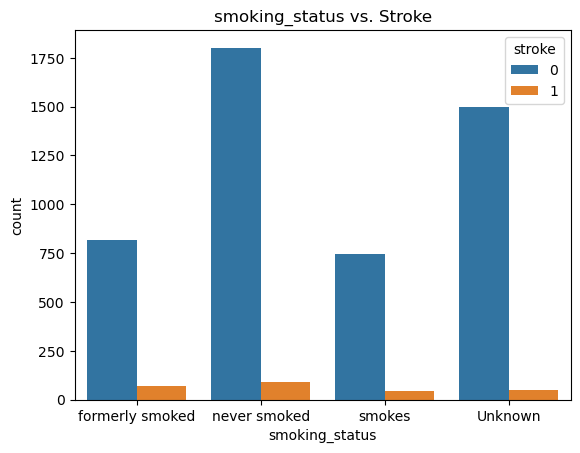

In [7]:
for cat in categorical_features:
    sns.countplot(x=cat, hue='stroke', data=data)
    plt.title(f"{cat} vs. Stroke")
    plt.show()

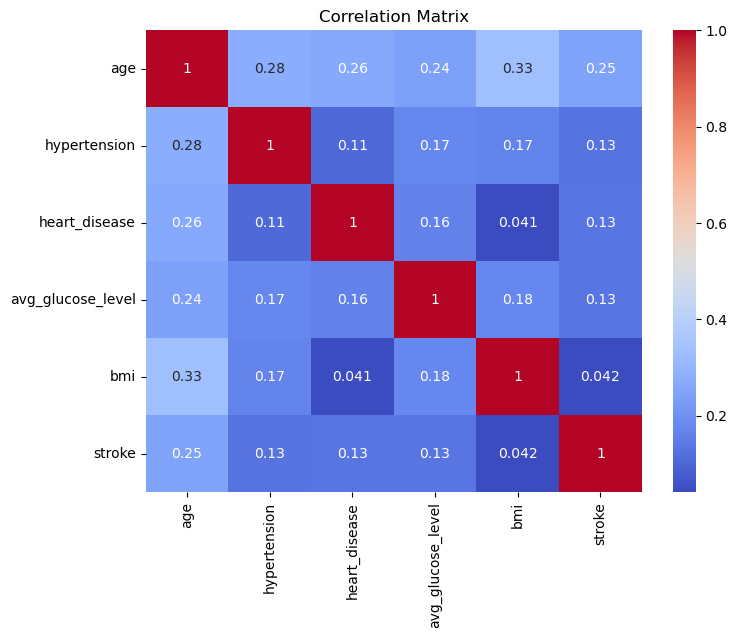

In [8]:

plt.figure(figsize=(8, 6))
sns.heatmap(data[all_numerical_features+ ['stroke']].corr(), annot=True, cmap='coolwarm')

plt.title("Correlation Matrix")
plt.show()


In [9]:
#chi square test
for column in categorical_features:  # List of categorical columns
    # Create a contingency table
    contingency_table = pd.crosstab(data[column], data['stroke'])
    
    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Display the results
    print(f"Feature: {column}")
    print(f"Chi-Square Statistic: {chi2:.2f}")
    print(f"P-Value: {p:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print("-" * 30)


Feature: gender
Chi-Square Statistic: 0.47
P-Value: 0.7895
Degrees of Freedom: 2
------------------------------
Feature: ever_married
Chi-Square Statistic: 58.92
P-Value: 0.0000
Degrees of Freedom: 1
------------------------------
Feature: work_type
Chi-Square Statistic: 49.16
P-Value: 0.0000
Degrees of Freedom: 4
------------------------------
Feature: Residence_type
Chi-Square Statistic: 1.08
P-Value: 0.2983
Degrees of Freedom: 1
------------------------------
Feature: smoking_status
Chi-Square Statistic: 29.15
P-Value: 0.0000
Degrees of Freedom: 3
------------------------------


In [10]:
# #Dropiing the features which have p>0.5

# X_updated = X.drop(columns=['gender', 'Residence_type'])
# categorical_features_updated=[feature for feature in categorical_features if feature not in ['gender', 'Residence_type']]

# X_updated.head()

In [11]:
# X_onehot = pd.get_dummies(X_updated[categorical_features_updated], columns=['ever_married', 'work_type', 'smoking_status'])

# X_onehot.head()


le = LabelEncoder()

# Apply LabelEncoder to the categorical columns
data_encoded = pd.DataFrame({
    'smoking_status': le.fit_transform(data['smoking_status']),
    'ever_married': le.fit_transform(data['ever_married']),
    'work_type': le.fit_transform(data['work_type']),
    'Residence_type': le.fit_transform(data['Residence_type']),
    'gender': le.fit_transform(data['gender'])
})

In [12]:
# X_onehot = pd.get_dummies(X_updated[categorical_features_updated], columns=['ever_married', 'work_type', 'smoking_status'], drop_first=True)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[numerical_features]),columns=['age', 'avg_glucose_level', 'bmi'])

X_scaled.head()


,age,avg_glucose_level,bmi
0,1.051434,2.706375,1.001234e+00
1,0.786070,2.121559,4.615554e-16
2,1.626390,-0.005028,4.685773e-01
3,0.255342,1.437358,7.154182e-01
4,1.582163,1.501184,-6.357112e-01


In [13]:
X_combined = pd.concat([X_scaled, data_encoded,X[binary_features]], axis=1)

X_combined.head()

,age,avg_glucose_level,bmi,smoking_status,ever_married,work_type,Residence_type,gender,hypertension,heart_disease
0,1.051434,2.706375,1.001234e+00,1,1,2,1,1,0,1
1,0.786070,2.121559,4.615554e-16,2,1,3,0,0,0,0
2,1.626390,-0.005028,4.685773e-01,2,1,2,0,1,0,1
3,0.255342,1.437358,7.154182e-01,3,1,2,1,0,0,0
4,1.582163,1.501184,-6.357112e-01,2,1,3,0,0,1,0


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)


# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

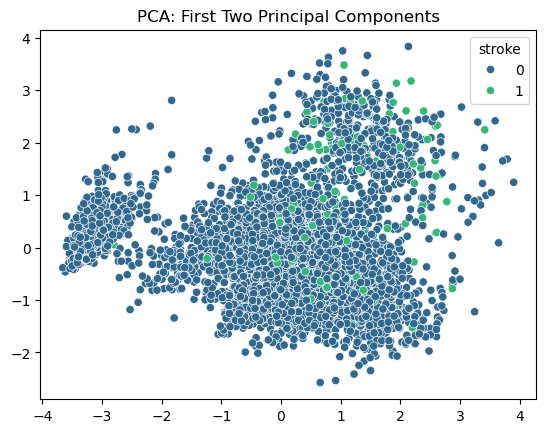

In [15]:
#PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='viridis')
plt.title("PCA: First Two Principal Components")
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


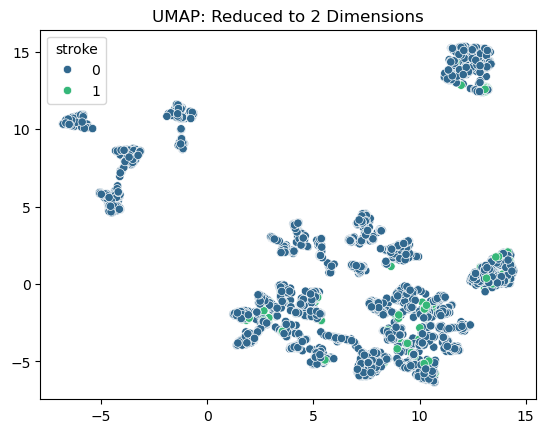

In [16]:
#UMAP

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_train)

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_train, palette='viridis')
plt.title("UMAP: Reduced to 2 Dimensions")
plt.show()


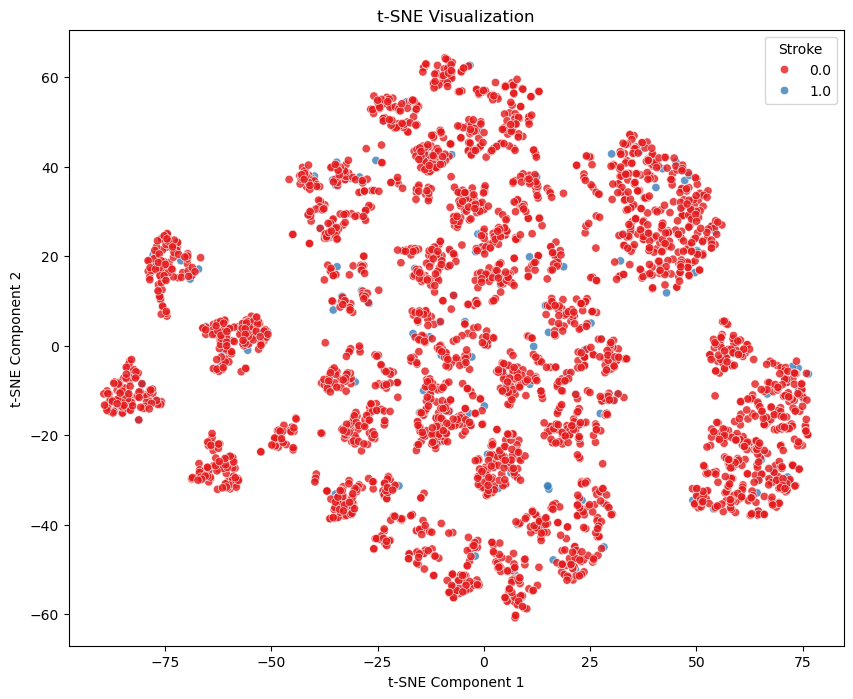

In [17]:
#t-SNE

tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_train_tsne = tsne_model.fit_transform(X_train)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(X_train_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['target'] = y_train  # Use the target variable

# Visualize t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='TSNE1', 
    y='TSNE2', 
    hue='target', 
    palette="Set1", 
    data=tsne_df, 
    alpha=0.8
)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Stroke", loc="upper right")
plt.show()

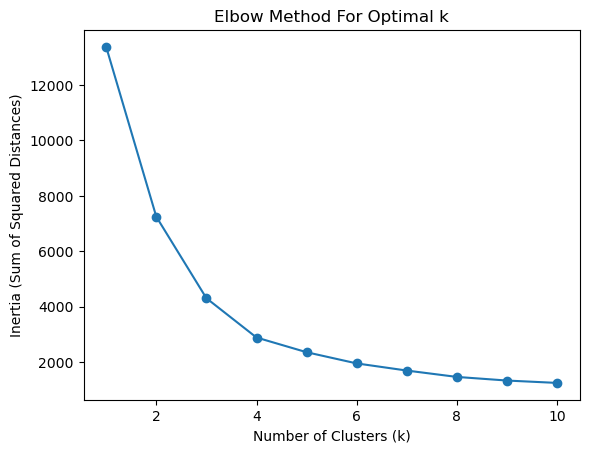

In [18]:
k_range = range(1, 11)

# List to store inertia (sum of squared distances)
inertia = []

# Loop through different k values
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)  # Fit K-Means on the PCA data
    inertia.append(kmeans.inertia_)  # Append the inertia for this k value

# Plot the elbow graph
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.show()

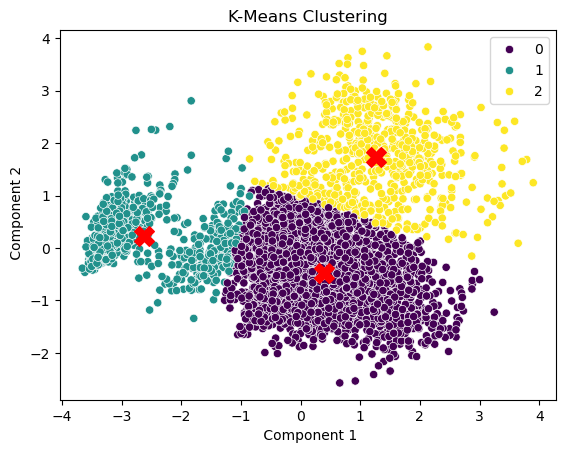

In [19]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# silhouette_avg = silhouette_score(X_pca, cluster_labels)
# print(f"Silhouette Score: {silhouette_avg}")

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis')

centroids = kmeans.cluster_centers_

# Plot centroids (red "X" markers)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroids')
plt.title("K-Means Clustering")
plt.xlabel(" Component 1")
plt.ylabel(" Component 2")
plt.show()

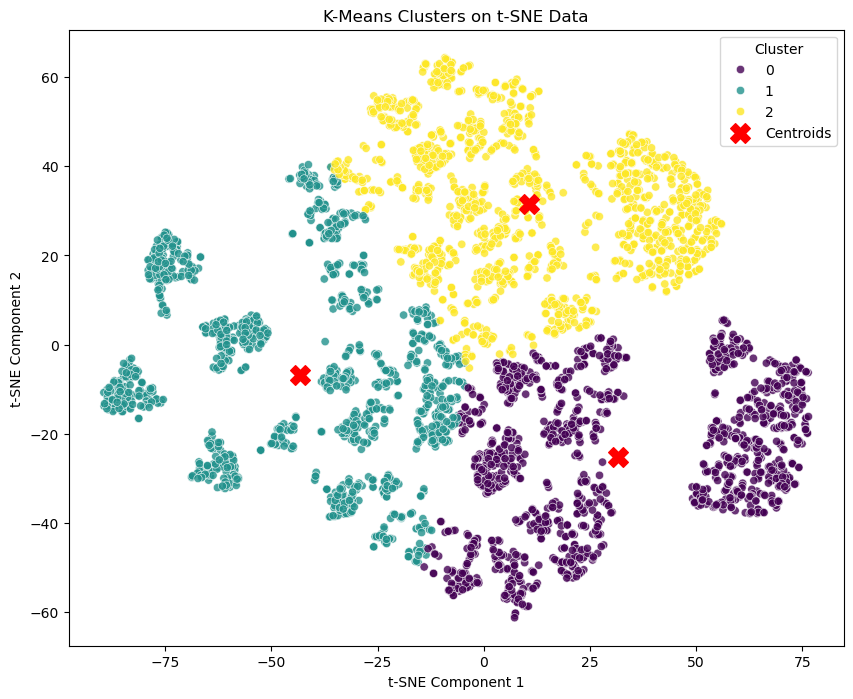

In [20]:
kmeans_tsne = KMeans(n_clusters=3, random_state=42)
kmeans_labels_tsne = kmeans_tsne.fit_predict(X_train_tsne)

tsne_df["Cluster"] = kmeans_labels_tsne

# Calculate centroids in the t-SNE-transformed space
tsne_centroids = tsne_df.groupby("Cluster")[["TSNE1", "TSNE2"]].mean().values

# Visualize K-Means Clusters on t-SNE Data
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_df['TSNE1'], 
    y=tsne_df['TSNE2'], 
    hue=tsne_df['Cluster'],  # Use the cluster labels for color
    palette="viridis", 
    alpha=0.8
)

# Plot centroids
plt.scatter(tsne_centroids[:, 0], tsne_centroids[:, 1], marker='X', s=200, c='red', label='Centroids')

plt.title("K-Means Clusters on t-SNE Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.show()

In [21]:
# Apply SMOTE to training data
# smote = SMOTE(random_state=42,k_neighbors=9)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# X_train_smote, X_test_new, y_train_smote, y_test_new = train_test_split(
#     X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
# )


print("Training data shape Before SMOTE:")
# print("X_train:", X_train.value_counts())
print("y_train:", y_train.value_counts())

print("Training data shape after SMOTE:")
# print("X_train_smote:", X_train_smote.value_counts())
print("y_train_smote:", y_train_smote.value_counts())

# print(X_test.shape)


Training data shape Before SMOTE:
y_train: stroke
0    3889
1     199
Name: count, dtype: int64
Training data shape after SMOTE:
y_train_smote: stroke
0    3889
1    3889
Name: count, dtype: int64


In [22]:


# Stratified k fold


X_train_np = X_train.to_numpy()  # Convert X_train to NumPy array
y_train_np = y_train.to_numpy()  # Convert y_train to NumPy array

# Create a StratifiedKFold object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Initialize models
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(scale_pos_weight=1, random_state=42)

# List to store results for each model
log_reg_scores = []
rf_scores = []
xgb_scores = []

# Cross-validation loop
for train_index, val_index in cv.split(X_train_np, y_train_np):
    X_train_fold, X_val_fold = X_train_np[train_index], X_train_np[val_index]
    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]
    
    # Apply SMOTE on the training fold
    X_train_smote_fold, y_train_smote_fold = smote.fit_resample(X_train_fold, y_train_fold)

    # Logistic Regression
    log_reg.fit(X_train_smote_fold, y_train_smote_fold)
    y_pred_log_reg = log_reg.predict(X_val_fold)
    y_pred_proba_log_reg = log_reg.predict_proba(X_val_fold)[:, 1]
    log_reg_accuracy = accuracy_score(y_val_fold, y_pred_log_reg)
    log_reg_roc_auc = roc_auc_score(y_val_fold, y_pred_proba_log_reg)
    log_reg_scores.append((log_reg_accuracy, log_reg_roc_auc))
    
    # Random Forest
    rf_model.fit(X_train_smote_fold, y_train_smote_fold)
    y_pred_rf = rf_model.predict(X_val_fold)
    y_pred_proba_rf = rf_model.predict_proba(X_val_fold)[:, 1]
    rf_accuracy = accuracy_score(y_val_fold, y_pred_rf)
    rf_roc_auc = roc_auc_score(y_val_fold, y_pred_proba_rf)
    rf_scores.append((rf_accuracy, rf_roc_auc))
    
    # XGBoost
    xgb_model.fit(X_train_smote_fold, y_train_smote_fold)
    y_pred_xgb = xgb_model.predict(X_val_fold)
    y_pred_proba_xgb = xgb_model.predict_proba(X_val_fold)[:, 1]
    xgb_accuracy = accuracy_score(y_val_fold, y_pred_xgb)
    xgb_roc_auc = roc_auc_score(y_val_fold, y_pred_proba_xgb)
    xgb_scores.append((xgb_accuracy, xgb_roc_auc))
    

# Print results for Logistic Regression

log_reg_avg_accuracy = np.mean([score[0] for score in log_reg_scores])
log_reg_avg_roc_auc = np.mean([score[1] for score in log_reg_scores])

print("StratifiedKFold\n")
print("Logistic Regression - Cross-Validation Scores:")
for i, (accuracy, roc_auc) in enumerate(log_reg_scores, 1):
    print(f"  Fold {i}: Accuracy = {accuracy:.4f}, ROC-AUC = {roc_auc:.4f}")
print(f"Logistic Regression - Average Accuracy: {log_reg_avg_accuracy:.4f}")
print(f"Logistic Regression - Average ROC-AUC: {log_reg_avg_roc_auc:.4f}")

# Print results for Random Forest
# Print detailed results for Random Forest
print("Random Forest - Cross-Validation Scores:")
for i, (accuracy, roc_auc) in enumerate(rf_scores, 1):
    print(f"  Fold {i}: Accuracy = {accuracy:.4f}, ROC-AUC = {roc_auc:.4f}")
rf_avg_accuracy = np.mean([score[0] for score in rf_scores])
rf_avg_roc_auc = np.mean([score[1] for score in rf_scores])
print(f"Random Forest - Average Accuracy: {rf_avg_accuracy:.4f}")
print(f"Random Forest - Average ROC-AUC: {rf_avg_roc_auc:.4f}")

# Print results for XGBoost
# Print detailed results for XGBoost
print("XGBoost - Cross-Validation Scores:")
for i, (accuracy, roc_auc) in enumerate(xgb_scores, 1):
    print(f"  Fold {i}: Accuracy = {accuracy:.4f}, ROC-AUC = {roc_auc:.4f}")
xgb_avg_accuracy = np.mean([score[0] for score in xgb_scores])
xgb_avg_roc_auc = np.mean([score[1] for score in xgb_scores])
print(f"XGBoost - Average Accuracy: {xgb_avg_accuracy:.4f}")
print(f"XGBoost - Average ROC-AUC: {xgb_avg_roc_auc:.4f}")

StratifiedKFold

Logistic Regression - Cross-Validation Scores:
  Fold 1: Accuracy = 0.7225, ROC-AUC = 0.8189
  Fold 2: Accuracy = 0.7543, ROC-AUC = 0.8509
  Fold 3: Accuracy = 0.7286, ROC-AUC = 0.8268
  Fold 4: Accuracy = 0.7356, ROC-AUC = 0.8296
  Fold 5: Accuracy = 0.7515, ROC-AUC = 0.8483
Logistic Regression - Average Accuracy: 0.7385
Logistic Regression - Average ROC-AUC: 0.8349
Random Forest - Cross-Validation Scores:
  Fold 1: Accuracy = 0.9156, ROC-AUC = 0.7972
  Fold 2: Accuracy = 0.9340, ROC-AUC = 0.8230
  Fold 3: Accuracy = 0.9181, ROC-AUC = 0.8065
  Fold 4: Accuracy = 0.9241, ROC-AUC = 0.7844
  Fold 5: Accuracy = 0.9412, ROC-AUC = 0.7947
Random Forest - Average Accuracy: 0.9266
Random Forest - Average ROC-AUC: 0.8012
XGBoost - Cross-Validation Scores:
  Fold 1: Accuracy = 0.9193, ROC-AUC = 0.7739
  Fold 2: Accuracy = 0.9364, ROC-AUC = 0.8184
  Fold 3: Accuracy = 0.9193, ROC-AUC = 0.7891
  Fold 4: Accuracy = 0.9302, ROC-AUC = 0.8056
  Fold 5: Accuracy = 0.9290, ROC-AUC = 0.7

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.14      0.78      0.24        50

    accuracy                           0.76      1022
   macro avg       0.56      0.77      0.55      1022
weighted avg       0.94      0.76      0.83      1022

ROC-AUC Score: 0.8234567901234568


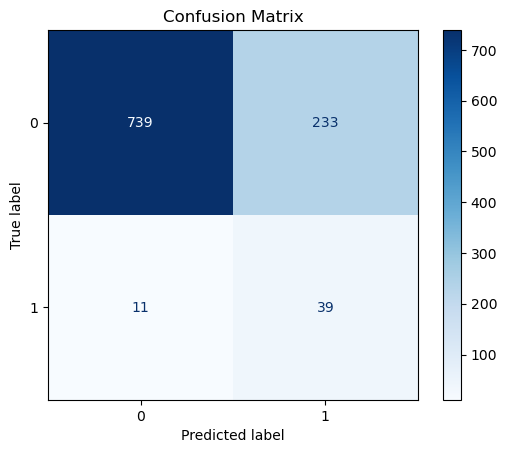

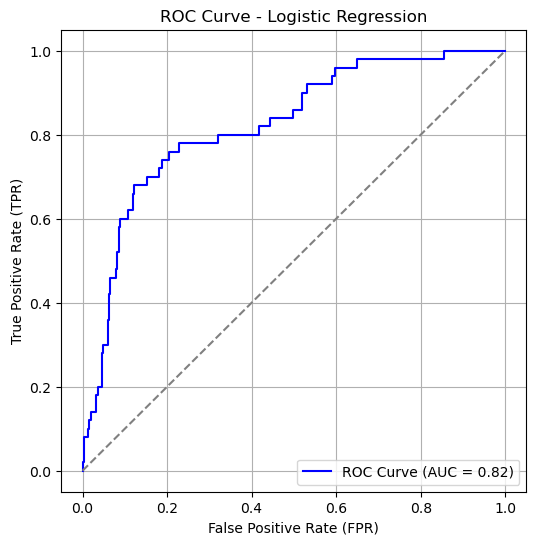

In [23]:
# Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train_smote, y_train_smote)

# Predictions and evaluation
y_pred_log_lr = log_reg.predict(X_test)
y_pred_proba_log_lr = log_reg.predict_proba(X_test)[:, 1]

# Classification Report and ROC-AUC Score
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_log_lr))
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_log_lr)
print(f"ROC-AUC Score: {roc_auc_lr}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_log_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_reg.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_log_lr)
plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, label=f"ROC Curve (AUC = {roc_auc_lr:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.show()


Random Forest Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       972
           1       0.13      0.22      0.16        50

    accuracy                           0.89      1022
   macro avg       0.54      0.57      0.55      1022
weighted avg       0.92      0.89      0.90      1022

Random Forest ROC-AUC Score: 0.7881893004115226


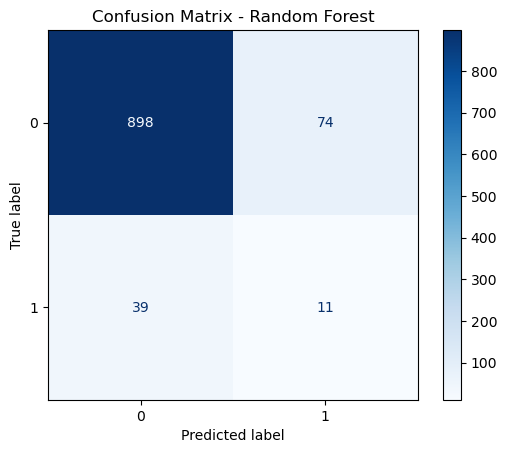

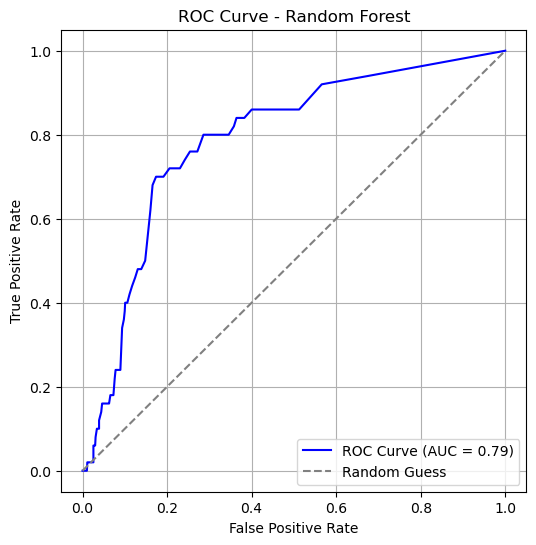

In [24]:
rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Predictions and evaluation
rf_y_pred = rf_model.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, rf_y_pred))
print("Random Forest ROC-AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

# ROC Curve: Calculate FPR, TPR, and thresholds
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# Calculate ROC-AUC score
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f"ROC Curve (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       972
           1       0.14      0.20      0.16        50

    accuracy                           0.90      1022
   macro avg       0.55      0.57      0.55      1022
weighted avg       0.92      0.90      0.91      1022

ROC-AUC Score: 0.78


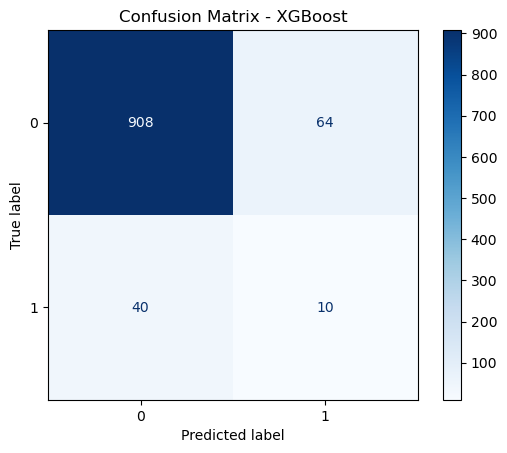

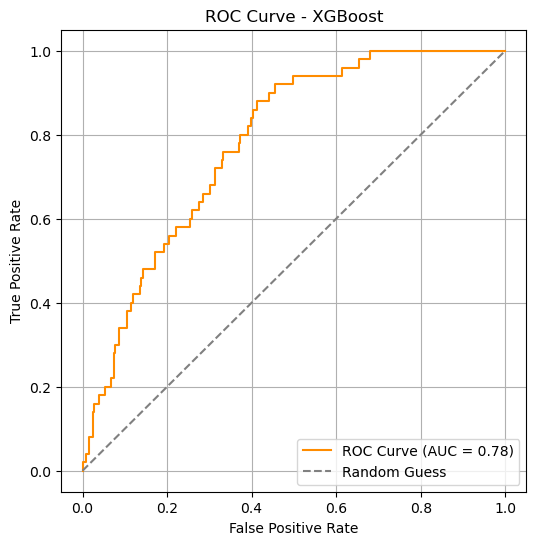

In [25]:
#XG Boost

xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1]),
    random_state=42,
    eval_metric="logloss"    # Specify evaluation metric to suppress deprecation warnings
)
xgb_model.fit(X_train_smote, y_train_smote)

# Step 3: Evaluate the model on the test data
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Classification report
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# ROC-AUC Score
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"ROC-AUC Score: {roc_auc_xgb:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC Curve (AUC = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.grid()
plt.show()


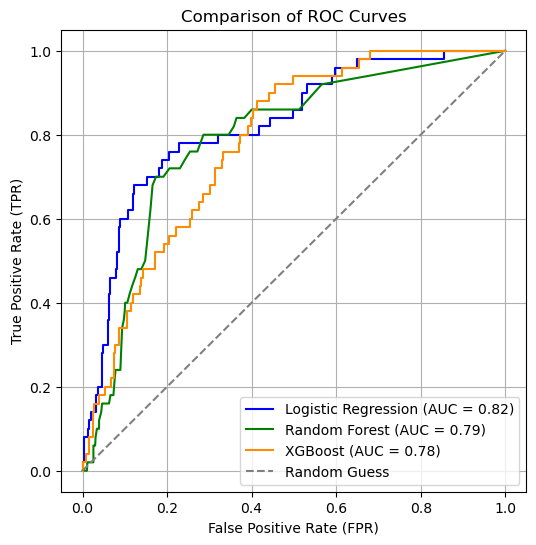

In [26]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_log_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot the ROC curves
plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", color='blue')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})", color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})", color='darkorange')

# Add the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")

# Labels, title, and legend
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Comparison of ROC Curves")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Hyperparameter Tuning and early stopping

In [27]:


# Define hyperparameter grid

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

# Grid search with StratifiedKFold
logreg_grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    param_grid=logreg_params,
    scoring='roc_auc',
    cv=strat_kfold,
    n_jobs=-1
)

logreg_grid.fit(X_train_smote, y_train_smote)
best_logreg = logreg_grid.best_estimator_

# Evaluate best Logistic Regression model
y_pred_logreg = best_logreg.predict(X_test)
y_pred_proba_logreg = best_logreg.predict_proba(X_test)[:, 1]
print("Best Logistic Regression Report:\n", classification_report(y_test, y_pred_logreg))
print(f"Best ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_logreg):.2f}")


Best Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.14      0.78      0.24        50

    accuracy                           0.76      1022
   macro avg       0.56      0.77      0.55      1022
weighted avg       0.94      0.76      0.83      1022

Best ROC-AUC Score: 0.82


In [28]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_distributions=rf_params,
    n_iter=50,
    scoring='roc_auc',
    cv=strat_kfold,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train_smote, y_train_smote)
best_rf = rf_random_search.best_estimator_

# Evaluate best Random Forest model
rf_y_pred = best_rf.predict(X_test)
print("Best Random Forest Report:\n", classification_report(y_test, rf_y_pred))
print(f"Best Random Forest ROC-AUC Score: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]):.2f}")


Best Random Forest Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       972
           1       0.13      0.22      0.16        50

    accuracy                           0.89      1022
   macro avg       0.54      0.57      0.55      1022
weighted avg       0.92      0.89      0.90      1022

Best Random Forest ROC-AUC Score: 0.79


In [29]:
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# XGBoost model with early stopping
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train_final[y_train_final == 0]) / len(y_train_final[y_train_final == 1]),
    eval_metric="logloss",
    random_state=42,
    early_stopping_rounds=10  # Stop training when validation performance doesn't improve
)

# Fit the model
xgb_model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_val, y_val)],  # Validation set for early stopping
    verbose=True
)

best_xgb = xgb_model
# Evaluate on test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Classification report
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# ROC-AUC Score
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"ROC-AUC Score: {roc_auc_xgb:.2f}")


[0]	validation_0-logloss:0.56578
[1]	validation_0-logloss:0.49724
[2]	validation_0-logloss:0.45109
[3]	validation_0-logloss:0.42450


[4]	validation_0-logloss:0.40749
[5]	validation_0-logloss:0.39302
[6]	validation_0-logloss:0.37626
[7]	validation_0-logloss:0.37073
[8]	validation_0-logloss:0.35542
[9]	validation_0-logloss:0.35090
[10]	validation_0-logloss:0.34523
[11]	validation_0-logloss:0.34132
[12]	validation_0-logloss:0.33667
[13]	validation_0-logloss:0.33489
[14]	validation_0-logloss:0.33143
[15]	validation_0-logloss:0.32490
[16]	validation_0-logloss:0.31940
[17]	validation_0-logloss:0.31092
[18]	validation_0-logloss:0.30805
[19]	validation_0-logloss:0.30051
[20]	validation_0-logloss:0.30004
[21]	validation_0-logloss:0.29829
[22]	validation_0-logloss:0.29498
[23]	validation_0-logloss:0.29414
[24]	validation_0-logloss:0.28953
[25]	validation_0-logloss:0.28778
[26]	validation_0-logloss:0.28777
[27]	validation_0-logloss:0.28508
[28]	validation_0-logloss:0.28210
[29]	validation_0-logloss:0.27848
[30]	validation_0-logloss:0.27407
[31]	validation_0-logloss:0.27187
[32]	validation_0-logloss:0.27036
[33]	validation_0-lo

Logistic Regression Performance

a. Cross-Validation Results:

1. ROC-AUC Scores: Average ROC-AUC = 0.82
Classification Report:
High precision and recall for class 0 (non-stroke cases).
Low precision (0.14) and recall (0.78) for class 1 (stroke cases).
2. Pitfalls:
The model is biased towards class 0 due to the imbalanced dataset.
Even with class_weight='balanced', the performance for class 1 remains suboptimal.
The model may not generalize well to unseen stroke cases.


b. Random Forest Performance
Cross-Validation Results:
1. ROC-AUC Scores: Average ROC-AUC = 0.79
Classification Report:
Excellent performance for class 0 (precision = 0.96, recall = 0.92).
Very poor performance for class 1 (precision = 0.13, recall = 0.22).
2. Pitfalls:
The model struggles with minority class detection (class 1).
Random Forest tends to overfit if hyperparameters are not well-tuned.
Subpar recall for class 1 implies the model is not suitable for critical applications like stroke prediction where detecting positives is crucial.


c. XGBoost Performance
Cross-Validation Results:
1. ROC-AUC Scores: Average ROC-AUC = 0.82
Classification Report:
Precision and recall for class 0 are excellent (0.96 each).
Precision (0.31) and recall (0.32) for class 1 are slightly better than Logistic Regression and Random Forest but still very low.
Logloss Performance:
The log-loss values stabilize during training, indicating that the model is not overfitting.
2. Pitfalls:
XGBoost's higher complexity may lead to overfitting on small datasets.
Despite handling imbalanced data using scale_pos_weight, the minority class performance is poor.
Early stopping does help prevent overfitting, but the recall for class 1 remains inadequate for critical use cases.

Potential Pitfalls
1. Misleading Metrics:
High accuracy and ROC-AUC are misleading due to class imbalance. The models are biased towards the majority class.
2. Critical Recall for Class 1:
Recall for class 1 (stroke cases) is crucial in this application. Low recall indicates a high rate of false negatives, which is unacceptable for healthcare-related predictions.
3. Class Imbalance:
SMOTE improves the balance but does not fully solve the problem due to possible synthetic data noise and overlap between classes.

Task 5

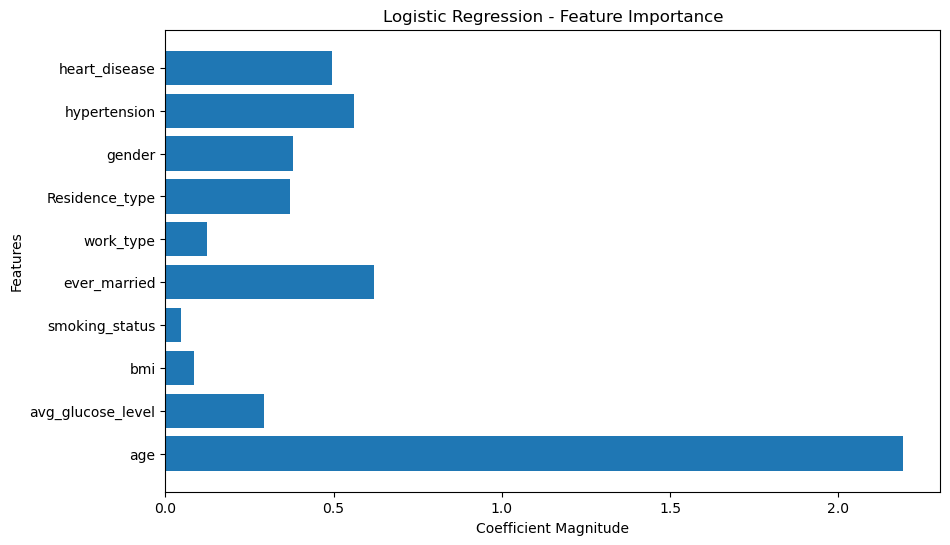

In [30]:

feature_importance_lr = np.abs(best_logreg.coef_[0])  # Absolute value of coefficients
features = X_train_smote.columns

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance_lr)
plt.title("Logistic Regression - Feature Importance")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Features")
plt.show()

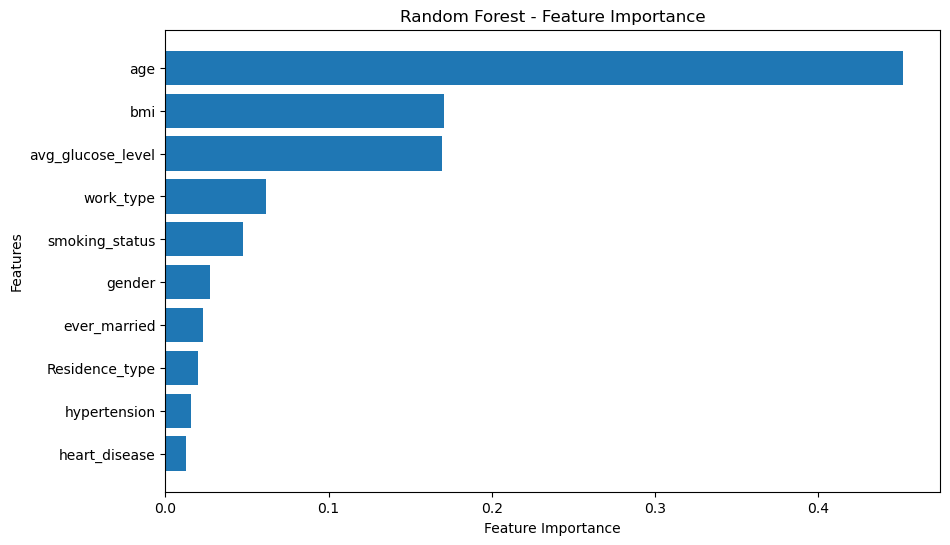

In [31]:
# Random Forest Feature Importance
feature_importance_rf = best_rf.feature_importances_
sorted_indices_rf = np.argsort(feature_importance_rf)

plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_indices_rf], feature_importance_rf[sorted_indices_rf])
plt.title("Random Forest - Feature Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()


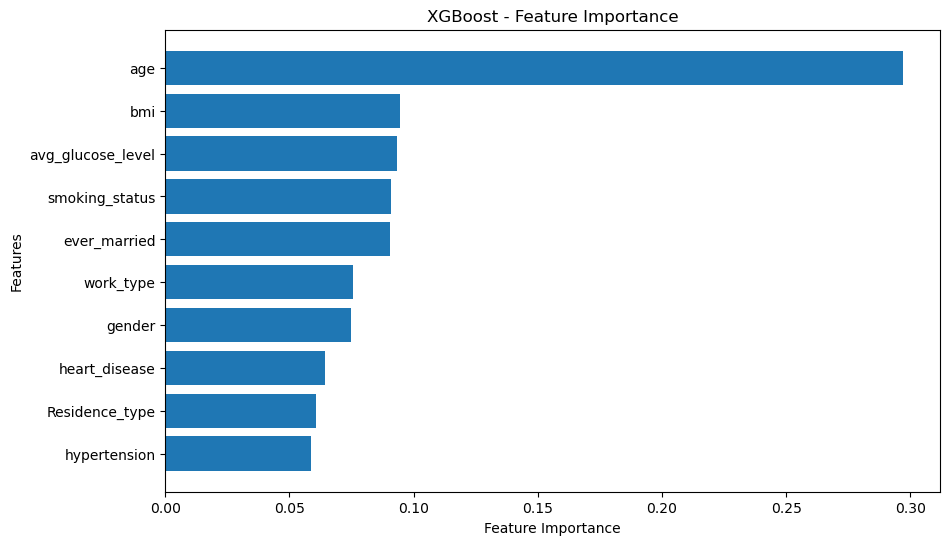

In [32]:
feature_importance_xgb = best_xgb.feature_importances_
sorted_indices_xgb = np.argsort(feature_importance_xgb)

plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_indices_xgb], feature_importance_xgb[sorted_indices_xgb])
plt.title("XGBoost - Feature Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

Experiment 1: Recursive Feature Elimination (RFE)

a. Objective: Select top features to simplify the model and reduce overfitting.

b. Method: Use RFE with Logistic Regression to rank features and train the model.

In [33]:
# Recursive Feature Elimination
rfe = RFE(estimator=LogisticRegression(class_weight='balanced', random_state=42), n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train_smote, y_train_smote)
X_test_rfe = rfe.transform(X_test)

# Train Logistic Regression on selected features
log_reg_rfe = LogisticRegression(class_weight='balanced', random_state=42)
log_reg_rfe.fit(X_train_rfe, y_train_smote)

# Evaluate
y_pred_rfe = log_reg_rfe.predict(X_test_rfe)
print("RFE Logistic Regression Report:\n", classification_report(y_test, y_pred_rfe))
print(f"ROC-AUC Score: {roc_auc_score(y_test, log_reg_rfe.predict_proba(X_test_rfe)[:, 1]):.2f}")

RFE Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.14      0.78      0.24        50

    accuracy                           0.76      1022
   macro avg       0.56      0.77      0.55      1022
weighted avg       0.94      0.76      0.83      1022

ROC-AUC Score: 0.82


Experiment 2: Logistic Regression with Regularization


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid with regularization
logreg_params = {
    'C': [0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # L1 for Lasso, L2 for Ridge
    'solver': ['liblinear']   # Solver for L1 and L2 regularization
}

logreg_grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    param_grid=logreg_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

logreg_grid.fit(X_train_smote, y_train_smote)
best_logreg = logreg_grid.best_estimator_

# Evaluate
y_pred_logreg = best_logreg.predict(X_test)
y_pred_proba_logreg = best_logreg.predict_proba(X_test)[:, 1]
print("Logistic Regression with Regularization Report:\n", classification_report(y_test, y_pred_logreg))
print(f"Best ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_logreg):.2f}")


Logistic Regression with Regularization Report:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.14      0.78      0.24        50

    accuracy                           0.76      1022
   macro avg       0.56      0.77      0.55      1022
weighted avg       0.94      0.76      0.83      1022

Best ROC-AUC Score: 0.82


Experiment 3: XGBoost with Advanced Sampling (ADASYN)

Use ADASYN to generate synthetic samples for the minority class.

Train an XGBoost model with hyperparameter tuning for scale_pos_weight, learning_rate, and tree depth.

Evaluate using cross-validation.

In [35]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# XGBoost with Hyperparameter Tuning
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [len(y_train_adasyn[y_train_adasyn == 0]) / len(y_train_adasyn[y_train_adasyn == 1])]
}

xgb_grid = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42), param_grid=xgb_params, cv=5, scoring='roc_auc', n_jobs=-1)
xgb_grid.fit(X_train_adasyn, y_train_adasyn)

# Evaluate the best model
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.2f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       972
           1       0.11      0.14      0.12        50

    accuracy                           0.90      1022
   macro avg       0.53      0.54      0.54      1022
weighted avg       0.91      0.90      0.91      1022

ROC-AUC Score: 0.79


Experiment 4: Regularization in XGBoost
XGBoost supports L1 (alpha) and L2 (lambda) regularization parameters.

In [36]:
from xgboost import XGBClassifier

# Define hyperparameter grid with regularization
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 2, 3],   # L2 regularization
    'scale_pos_weight': [1, 2, 3]
}

xgb_grid = GridSearchCV(
    XGBClassifier(eval_metric="logloss", random_state=42),
    param_grid=xgb_params,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

xgb_grid.fit(X_train_smote, y_train_smote)
best_xgb_reg = xgb_grid.best_estimator_

# Evaluate
y_pred_xgb_reg = best_xgb_reg.predict(X_test)
y_pred_proba_xgb_reg = best_xgb_reg.predict_proba(X_test)[:, 1]
print("XGBoost with Regularization Report:\n", classification_report(y_test, y_pred_xgb_reg))
print(f"Best ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb_reg):.2f}")


XGBoost with Regularization Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       972
           1       0.15      0.28      0.19        50

    accuracy                           0.89      1022
   macro avg       0.55      0.60      0.57      1022
weighted avg       0.92      0.89      0.90      1022

Best ROC-AUC Score: 0.78


Experiment 5:  Neural Networks with More Layers

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout



# Build the Neural Network
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_smote.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train_smote, y_train_smote, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate on test data
y_pred_nn_proba = model.predict(X_test)
y_pred_nn = (y_pred_nn_proba > 0.5).astype(int)
print("Neural Network Report:\n", classification_report(y_test, y_pred_nn))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_nn_proba):.2f}")


Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step - accuracy: 0.7089 - loss: 0.5442 - val_accuracy: 0.7281 - val_loss: 0.6074
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - accuracy: 0.7831 - loss: 0.4337 - val_accuracy: 0.8284 - val_loss: 0.4815
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - accuracy: 0.7974 - loss: 0.4210 - val_accuracy: 0.8278 - val_loss: 0.4988
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - accuracy: 0.7959 - loss: 0.4059 - val_accuracy: 0.8496 - val_loss: 0.4757
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.7889 - loss: 0.4116 - val_accuracy: 0.8580 - val_loss: 0.4219
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - accuracy: 0.7989 - loss: 0.4039 - val_accuracy: 0.8875 - val_loss: 0.4100
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - accuracy: 0.8125 - loss: 0.3941 - val_accuracy: 0.8856 - val_loss: 0.4167
Epoch 8/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.8117 - loss: 0.3882 - val_accurac